# <center><span> Microtom co-expression network analysis </span> </center>

### Bringing it all together:
In Project 1, I used a Pearson Correlation Coefficient (PCC) method to construct a simple gene network from gene expression data. In Project 2, I applied k-means clustering to separate metabolites into clusters based on their pattern of accumulation across the 20 tissue samples collected. Because of the close interplay between a plant's chemical and transcriptional status, these gene expression and metabolite accumulation datasets can be integrated together to form a co-expression network. This should allow for identification of not only genes acting in metabolite biosynthesis, but also those are directly and indirectly regulated by the chemical status of the plant. Genes which play a role in upstream signaling for chemical shifts (e.g. hormone receptors) should also be highlighted by the network.

<img src="fig1.PNG" width="800"><br/>
Illustration of tissue samples taken to generate gene expression dataset for MicroTom (Li et al., 2020).

For example, consider a plant hormone, such as indole-3-acetic acid (aka auxin). Auxin is known to promote plant growth by signaling for stem and root elongation. In a co-expression network, auxin should form connections with both auxin biosyntheis and auxin response genes. Because auxin is synthesized in response to a variety of abiotic triggers (e.g. light and gravity), auxin should also form connections with receptors acting in these pathways. With this approach, a metabolite can be placed into biological context by considering genes acting upstream, in its biosynthesis, and downstream. This allows for us to develop an understanding of the bidirectional communication between gene expression and metabolite accumulation.

To develop this co-expression network, I will combine methods that I've previously presented in Projects 1 and 2. First, I will use Pearson's Correlation Coefficient (PCC) to correlate together metabolite accumulation and gene expression for the entire dataset. I will then apply filtering to randomly select a small subset of genes and metabolites which have significant associations. I'll log the most significant associations in this subset, and save that as a .csv file. To another .csv file, I'll also save information about the genes and metabolites in the subset, including the cluster to which each metabolite belongs (determined in Project 2). I'll apply another round of PCC to correlate the subset of genes against themselves to identify gene-gene interactions, similar to what I presented in Project 1. I'll save the most significant interactions to one more .csv file. Finally, I'll use the visNetwork library in R to merge together these .csv files, and draw an interactive co-expression network.

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns; sns.set(rc={'figure.figsize':(8,8)})
import matplotlib.pyplot as plt
import copy
from scipy import stats

Load the gene expression and metabolite dataset from a .csv file, and create numpy arrays containing only expression/accumulation data (no metadata).

In [2]:
# Load gene expression dataset
exprData = pd.read_csv(filepath_or_buffer="microtomGeneExpression.csv", header=2)
exprData = exprData.set_index("Gene")

# Load metabolite accumulation dataset
metDataTF = pd.read_csv(filepath_or_buffer="metConcDataTF.csv")
metDataTF = metDataTF.set_index("Index")

# Create dataframes with only data
onlyExprData = exprData.iloc[:, 5:exprData.shape[1]]
onlyExprData.index = exprData.index
onlyMetDataTF = metDataTF.iloc[:, 8:metDataTF.shape[1]-1]
onlyMetDataTF.index = metDataTF.index

In [3]:
# Normalize the gene expression dataset using a sample-wise z-score normalization
onlyExprDataTF = stats.zscore(onlyExprData, axis=1)
onlyExprDataTF = pd.DataFrame(onlyExprDataTF, columns=onlyExprData.columns, index=onlyExprData.index)
exprDataTF = exprData.iloc[:, 0:5]
exprDataTF = pd.concat([exprDataTF, onlyExprDataTF], axis=1)

I'll apply the built-in PCC function from numpy to calculate gene-metabolite associations for all genes and metabolites. This step can take a while (10-30 mins!) so it's best to save the output into a .csv file which can be loaded when needed. Just as in the correlation matrix generated in Project 1, the values in this correlation matrix range between -1 and 1. A value of -1 represents a perfect negative correlation (e.g. concentration of metabolite increases while expression of gene decreases), and a value of 1 represents a perfect positive correlation (e.g. concentration of metabolite increases while expression of gene increases). Each row in the correlation matrix represents a metabolite, and each column a gene.

In [9]:
# Only needs to be run once!
# Creates a correlation matrix - each row represents a metabolite, and each column a gene.
metExprPCC = np.zeros(shape=(onlyMetDataTF.shape[0], onlyExprDataTF.shape[0]))
for row in range(0, metExprPCC.shape[0]):
    for col in range(0, metExprPCC.shape[1]):
        metExprPCC[row, col] = np.corrcoef(onlyMetDataTF.iloc[row, :], onlyExprDataTF.iloc[col, :])[1, 0]
metExprPCC = pd.DataFrame(data=metExprPCC, index=onlyMetDataTF.index, columns=onlyExprDataTF.index)
metExprPCC.to_csv(path_or_buf="metExprPCC.csv")

If the gene-metabolite correlation matrix has already been generated, it can just be loaded from the .csv file. Let's take a look at a summary of the first 5 rows in the matrix dataframe to understand its format.

In [4]:
metExprPCC = pd.read_csv(filepath_or_buffer="metExprPCC.csv", header=0, index_col=0)
metExprPCC.head()

FileNotFoundError: [Errno 2] No such file or directory: 'metExprPCC.csv'

The correlations in the matrix that are most significant are the ones that are either closest to -1 or to 1. These significant correlations are most likely to represent an actual relationship between a gene and a metabolite.

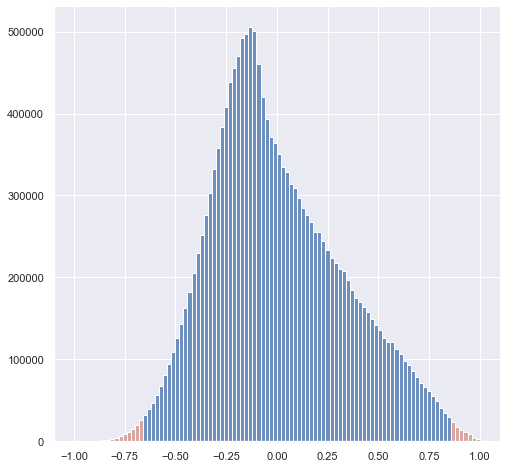

In [5]:
metExprList = (metExprPCC.to_numpy()).flatten()
lowCutoff = np.percentile(metExprList, 0.5)
highCutoff = np.percentile(metExprList, 99.5)

n, bins, patches = plt.hist(metExprList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

To reduce the size of the dataset, I'll filter the set column-wise to remove any genes which have no significantly associated metabolites. I'll also remove any filtered genes from the original metData and exprData dataframes. Finally, I'll separate the list of genes in the exprData dataframe into two: one with genes with positive associations, and one with genes with negative associations. The final result will be a much smaller and more manageable dataset which contains only genes with signficant metabolite associations.

In [6]:
# Filter out any genes which have no significant metabolite associations.
genesToDrop = list(set(exprDataTF.index) - set(metExprPCC.columns))
filteredMetExprPCC = copy.deepcopy(metExprPCC)

# Filter for significant genes with at least 1 association.
for col in range(0, metExprPCC.shape[1]):
    if sum(filteredMetExprPCC.iloc[:, col] > highCutoff) == 0 and sum(filteredMetExprPCC.iloc[:, col] < lowCutoff) == 0:
        genesToDrop.append(filteredMetExprPCC.columns[col])
filteredMetExprPCC = filteredMetExprPCC.drop(genesToDrop, axis=1, errors="ignore")
exprDataTF = exprDataTF.drop(genesToDrop, axis=0, errors="ignore") # also drop from expression dataframe

# Use metExprPCC to separate exprData dataframe into genes with positive associations and genes with negative associations. Add column to separated data for cluster info - gene cluster should be the metabolite cluster which the metabolite the gene was most strongly associated with belongs.
exprDataTF.insert(0, "Cluster", np.nan)
exprDataPositive = pd.DataFrame(columns=exprDataTF.columns)
exprDataNegative = pd.DataFrame(columns=exprDataTF.columns)
for col in range(0, filteredMetExprPCC.shape[1]):
    geneID = filteredMetExprPCC.columns[col]
    metID = filteredMetExprPCC.iloc[:, col].abs().idxmax()
    exprDataTF.loc[geneID, "Cluster"] = metDataTF.loc[metID, "Cluster"]
    if sum(filteredMetExprPCC.iloc[:, col] > highCutoff):
        geneID = filteredMetExprPCC.columns[col]
        exprDataPositive = exprDataPositive.append(exprDataTF.loc[geneID])
        metID = filteredMetExprPCC.iloc[:, col].idxmax()
        exprDataPositive.loc[geneID, "Cluster"] = metDataTF.loc[metID, "Cluster"]
    if sum(filteredMetExprPCC.iloc[:, col] < lowCutoff):
        geneID = filteredMetExprPCC.columns[col]
        exprDataNegative = exprDataNegative.append(exprDataTF.loc[geneID])
        metID = filteredMetExprPCC.iloc[:, col].idxmin()
        exprDataNegative.loc[geneID, "Cluster"] = metDataTF.loc[metID, "Cluster"]

#exprDataTF.to_csv(path_or_buf="exprDataCombined.csv")
#exprDataPositive.to_csv(path_or_buf="exprDataPositive.csv")
#exprDataNegative.to_csv(path_or_buf="exprDataNegative.csv")

In [7]:
# Summarize gene and metabolite data into averages for each cluster and create line graphs comparing gene expression data to metabolite accumulation for each cluster
meanExprDataPositive = exprDataPositive.drop(exprDataPositive.iloc[:, 1:6], axis=1)
meanExprDataPositive = meanExprDataPositive.groupby("Cluster").mean()
meanExprDataPositive.reset_index(level=0, inplace=True)
meanExprDataPositive["Type"] = "Positively associated genes"
meanExprDataPositive["Row"] = np.repeat([0, 1], [5, 5], axis=0) # for drawing faceted graphs
meanExprDataPositive["Col"] = [0,1,2,3,4]*2 # for drawing faceted graphs

meanExprDataNegative = exprDataNegative.drop(exprDataNegative.iloc[:, 1:6], axis=1)
meanExprDataNegative = meanExprDataNegative.groupby("Cluster").mean()
meanExprDataNegative.reset_index(level=0, inplace=True)
meanExprDataNegative["Type"] = "Negatively associated genes"
meanExprDataNegative["Row"] = np.repeat([0, 1], [5, 5], axis=0) # for drawing faceted graphs
meanExprDataNegative["Col"] = [0,1,2,3,4]*2 # for drawing faceted graphs

meanMetData = metDataTF.iloc[:, 8:metDataTF.shape[1]].groupby("Cluster").mean()
meanMetData.reset_index(level=0, inplace=True)
meanMetData["Type"] = "Metabolites"
meanMetData["Row"] = np.repeat([0, 1], [5, 5], axis=0) # for drawing faceted graphs
meanMetData["Col"] = [0,1,2,3,4]*2 # for drawing faceted graphs

plotData = pd.concat([meanExprDataPositive, meanExprDataNegative, meanMetData], axis=0)
plotData = pd.melt(plotData, id_vars=["Cluster", "Row", "Col", "Type"], var_name="Sample", value_name="Z-score")

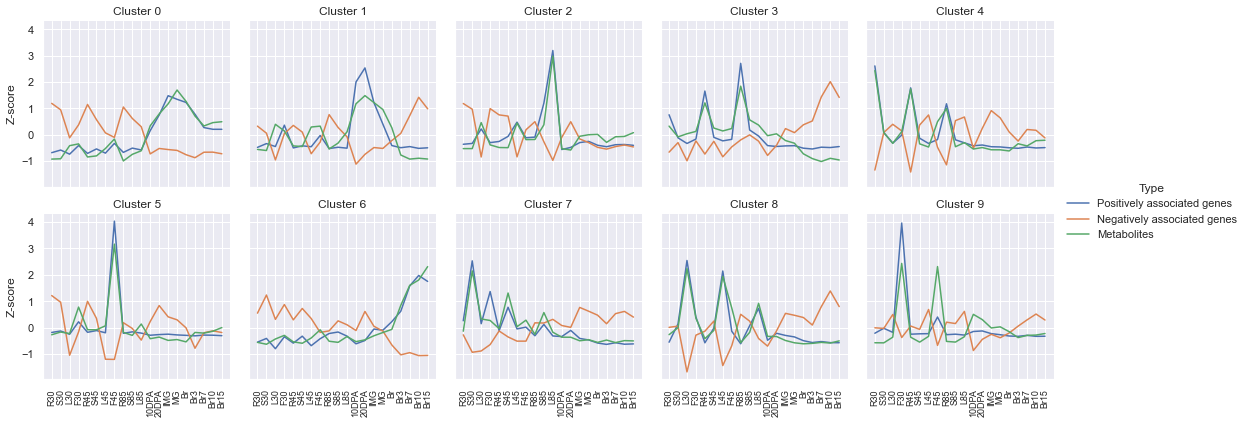

In [8]:
clusterPlot = sns.FacetGrid(plotData, row="Row", col="Col", hue="Type", legend_out=True)
clusterPlot.map(sns.lineplot, "Sample", "Z-score")
clusterPlot.set(xlabel=None)
clusterPlot.set_xticklabels(rotation=90, size=9)
clusterPlot.add_legend()
for ax, title in zip(clusterPlot.axes.flat, ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9"]):
    ax.set_title(title)

In [10]:
# Subset metabolite dataset to only include flavonoids and hydroxycinnamoyls + derivatives, then filter out any genes that have no significant associations with this subset of metabolites.
subsetMetDataTF = metDataTF[metDataTF.Class.isin(["Flavonoids", "Hydroxycinnamoyl and derivatives"])]

# Filter out any genes which have no significant metabolite associations.
genesToDrop = list(set(exprDataTF.index) - set(filteredMetExprPCC.columns))
subsetMetExprPCC = filteredMetExprPCC[filteredMetExprPCC.index.isin(subsetMetDataTF.index)]

# Filter for significant genes with at least 1 association.
for col in range(0, subsetMetExprPCC.shape[1]):
    if sum(subsetMetExprPCC.iloc[:, col] > highCutoff) == 0 and sum(subsetMetExprPCC.iloc[:, col] < lowCutoff) == 0:
        genesToDrop.append(filteredMetExprPCC.columns[col])
subsetMetExprPCC = subsetMetExprPCC.drop(genesToDrop, axis=1, errors="ignore")
subsetExprDataTF = exprDataTF.drop(genesToDrop, axis=0, errors="ignore") # also drop from expression dataframe

# Use subsetMetExprPCC to separate exprData dataframe into genes with positive associations and genes with negative associations. Add column to separated data for cluster info - gene cluster should be the metabolite cluster which the metabolite the gene was most strongly associated with belongs.
subsetExprDataPositive = pd.DataFrame(columns=subsetExprDataTF.columns)
subsetExprDataNegative = pd.DataFrame(columns=subsetExprDataTF.columns)
for col in range(0, subsetMetExprPCC.shape[1]):
    if sum(subsetMetExprPCC.iloc[:, col] > highCutoff):
        geneID = subsetMetExprPCC.columns[col]
        subsetExprDataPositive = subsetExprDataPositive.append(subsetExprDataTF.loc[geneID])
        metID = subsetMetExprPCC.iloc[:, col].idxmax()
        subsetExprDataPositive.loc[geneID, "Cluster"] = subsetMetDataTF.loc[metID, "Cluster"]
    if sum(subsetMetExprPCC.iloc[:, col] < lowCutoff):
        geneID = subsetMetExprPCC.columns[col]
        subsetExprDataNegative = subsetExprDataNegative.append(subsetExprDataTF.loc[geneID])
        metID = subsetMetExprPCC.iloc[:, col].idxmin()
        subsetExprDataNegative.loc[geneID, "Cluster"] = subsetMetDataTF.loc[metID, "Cluster"]

# Save the subset metabolite and gene lists - these will be "node" data in the network.
subsetMetDataTF.to_csv(path_or_buf="networkData/metData.csv")
subsetExprDataTF.to_csv(path_or_buf="networkData/exprDataCombined.csv")
subsetExprDataPositive.to_csv(path_or_buf="networkData/exprDataPositive.csv")
subsetExprDataNegative.to_csv(path_or_buf="networkData/exprDataNegative.csv")

I'll also record the metabolite-gene associations that were most significant in the subset of data. To a dataframe, I'll enter the metabolite and gene involved in each significant association, as well whether the correlation was positive or negative. In network analysis, these significant associations which connect 2 nodes are usually referred to as "edges". 

In [12]:
# Create a dataframe with significant metabolite-genes associations and save for use later - this will be "edge" data in the network.
subsetMetExprEdges = pd.DataFrame(columns=["Gene", "Metabolite", "Direction"])
for row in range(0, subsetMetExprPCC.shape[0]):
    for col in range(0, subsetMetExprPCC.shape[1]):
        if subsetMetExprPCC.iloc[row, col] > highCutoff:
            subsetMetExprEdges = subsetMetExprEdges.append({"Gene":subsetMetExprPCC.columns[col], "Metabolite":subsetMetExprPCC.index[row], "Direction":"+"}, ignore_index=True)
        elif subsetMetExprPCC.iloc[row, col] < lowCutoff:
            subsetMetExprEdges = subsetMetExprEdges.append({"Gene":subsetMetExprPCC.columns[col], "Metabolite":subsetMetExprPCC.index[row], "Direction":"-"}, ignore_index=True)
subsetMetExprEdges.to_csv(path_or_buf="networkData/metExprEdgesCombined.csv")

In [35]:
# Separate list of edges into positive and negative associations
metExprEdgesPositive = subsetMetExprEdges[subsetMetExprEdges.Direction == "+"]
metExprEdgesPositive.to_csv(path_or_buf="networkData/metExprEdgesPositive.csv")

metExprEdgesNegative = subsetMetExprEdges[subsetMetExprEdges.Direction == "-"]
metExprEdgesNegative.to_csv(path_or_buf="networkData/metExprEdgesNegative.csv")

To calculate gene-gene associations, a similar workflow as that applied in Project 1 will be used here. The only major difference is that I'll use numpy's built-in function for calculating PCC instead of creating a function myself.

In [15]:
# Create correlation matrix for gene-gene interactions
# Regenerate expression data array from filtered genes
onlyExprDataTF = np.array(subsetExprDataTF.iloc[:, 6:subsetExprDataTF.shape[1]])
exprPCC = np.zeros(shape=(onlyExprDataTF.shape[0], onlyExprDataTF.shape[0]))
for row in range(0, exprPCC.shape[0]):
    for col in range(0, exprPCC.shape[1]):
        exprPCC[row, col] = np.corrcoef(onlyExprDataTF[row, :], onlyExprDataTF[col, :])[1, 0]
exprPCC = pd.DataFrame(data=exprPCC, index=subsetExprDataTF.index, columns=subsetExprDataTF.index)
exprPCC.to_csv(path_or_buf="exprPCC.csv")
exprPCC.head()

Gene,Solyc00g005000.3,Solyc00g005050.3,Solyc00g005080.2,Solyc00g005094.1,Solyc00g005840.3,Solyc00g006480.1,Solyc00g006800.3,Solyc00g006867.1,Solyc00g007100.3,Solyc00g007220.3,...,Solyc12g100020.1,Solyc12g100030.2,Solyc12g100050.2,Solyc12g100140.2,Solyc12g100160.2,Solyc12g100180.2,Solyc12g100190.2,Solyc12g100270.2,Solyc12g100280.2,Solyc12g100340.1
Gene,,,,,,,,,,,,,,,,,,,,,
Solyc00g005000.3,1.000000,-0.194323,0.755875,-0.259131,-0.376816,0.085881,0.707259,0.811190,0.173519,-0.244220,...,-0.143014,-0.235626,0.511881,0.276801,-0.246751,-0.106924,-0.124014,0.928037,-0.235553,-0.156266
Solyc00g005050.3,-0.194323,1.000000,0.128842,0.657204,-0.517058,-0.268981,0.150550,-0.217237,-0.137795,0.851847,...,-0.345047,-0.392496,0.186492,-0.758700,-0.478366,-0.260220,-0.290799,-0.224699,-0.502471,-0.248875
Solyc00g005080.2,0.755875,0.128842,1.000000,0.076866,-0.252274,0.005891,0.416648,0.713889,0.187123,-0.013245,...,-0.091738,-0.189836,0.251419,0.138710,-0.112049,-0.113537,-0.134195,0.725153,-0.181542,0.010811
Solyc00g005094.1,-0.259131,0.657204,0.076866,1.000000,-0.233262,-0.178802,-0.040453,-0.190065,0.043639,0.698451,...,-0.202748,-0.231062,0.313848,-0.435807,-0.270325,-0.146431,-0.152973,-0.203693,-0.330833,0.014559
Solyc00g005840.3,-0.376816,-0.517058,-0.252274,-0.233262,1.000000,-0.118049,-0.813179,-0.133848,-0.310047,-0.450469,...,0.145514,0.829427,-0.626685,0.340779,0.885564,-0.038879,-0.016000,-0.263283,0.252925,0.775746


I'll calculate significant gene-gene associations by calculating correlations values at the 5th and 95th percentiles of all correlations.

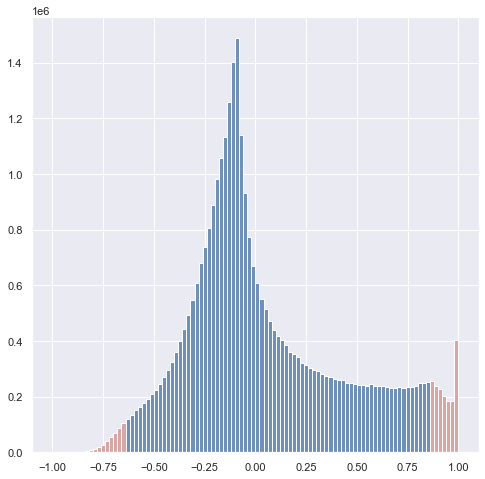

In [21]:
exprList = np.triu(exprPCC.to_numpy(), k=1)
exprList = exprList.flatten()
exprList = exprList[exprList!=0]

lowCutoff = np.percentile(exprList, 1)
highCutoff = np.percentile(exprList, 95)

n, bins, patches = plt.hist(exprList, bins=100, range=[-1, 1])
for c, p in zip(bins, patches):
    if c < lowCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
    elif c >= lowCutoff and c < highCutoff:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[0])
    else:
        plt.setp(p, 'facecolor', sns.color_palette("vlag")[4])
plt.show()

I'll save any gene-gene association which fall above the upper threshold, or below the lower threshold. To a dataframe, I'll log the 2 genes involved in each association, as well as whether the correlation was positive or negative. I'll save this "edge" dataframe to the preprocessedData folder.

In [28]:
# Create a dataframe with gene-gene edges and save
upperExprPCC = pd.DataFrame(np.triu(exprPCC.to_numpy(), k=1), index=exprPCC.index, columns=exprPCC.columns)
exprEdges = pd.DataFrame(columns=["Gene1", "Gene2", "Direction"])
for row in range(0, upperExprPCC.shape[0]):
    for col in range(0, upperExprPCC.shape[1]):
        if upperExprPCC.iloc[row, col] > highCutoff:
            exprEdges = exprEdges.append({"Gene1":upperExprPCC.index[row], "Gene2":upperExprPCC.columns[col], "Direction":"+"}, ignore_index=True)
        elif upperExprPCC.iloc[row, col] < lowCutoff:
            exprEdges = exprEdges.append({"Gene1":upperExprPCC.index[row], "Gene2":upperExprPCC.columns[col], "Direction":"-"}, ignore_index=True)
exprEdges = exprEdges.drop_duplicates() # If run is split up, need to remove duplicates
exprEdges.to_csv(path_or_buf="networkData/exprEdgesCombined.csv")


In [34]:
# Filter edge dataset into 2 separate files for positive and negative gene-metabolite associations
exprEdgesPositive = exprEdges[exprEdges.Gene1.isin(subsetExprDataPositive.index)]
exprEdgesPositive = exprEdgesPositive[exprEdgesPositive.Gene2.isin(subsetExprDataPositive.index)]
exprEdgesPositive.to_csv(path_or_buf="networkData/exprEdgesPositive.csv")

exprEdgesNegative = exprEdges[exprEdges.Gene1.isin(subsetExprDataNegative.index)]
exprEdgesNegative = exprEdgesNegative[exprEdgesNegative.Gene2.isin(subsetExprDataNegative.index)]
exprEdgesNegative.to_csv(path_or_buf="networkData/exprEdgesNegative.csv")